In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from collections import OrderedDict

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs
import pyDOE2

from agnfinder.prospector import main, cpz_builders, visualise
from agnfinder import simulation_utils

In [3]:
os.chdir('/home/mike/repos/agnfinder')

In [4]:
!pwd

/home/mike/repos/agnfinder


# Setup

In [15]:
galaxy_index = 1
galaxy = main.load_galaxy(galaxy_index)
redshift = galaxy['redshift']

In [16]:
agn_mass = True
agn_eb_v = True
agn_torus_mass = True
igm_absorbtion = True
emulate_ssp = True

In [17]:
run_params, obs, model, sps = main.construct_problem(galaxy, redshift=redshift, agn_mass=agn_mass, agn_eb_v=agn_eb_v, agn_torus_mass=agn_torus_mass, igm_absorbtion=igm_absorbtion, emulate_ssp=emulate_ssp)

[<class 'sedpy.observate.Filter'>(u_sloan), <class 'sedpy.observate.Filter'>(g_sloan), <class 'sedpy.observate.Filter'>(r_sloan), <class 'sedpy.observate.Filter'>(i_sloan), <class 'sedpy.observate.Filter'>(z_sloan), <class 'sedpy.observate.Filter'>(VISTA_H), <class 'sedpy.observate.Filter'>(VISTA_J), <class 'sedpy.observate.Filter'>(VISTA_Ks), <class 'sedpy.observate.Filter'>(VISTA_Y), <class 'sedpy.observate.Filter'>(VISTA_Z), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2)]


 /media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning:Trying to unpickle estimator PCA from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.


In [18]:
sps

In [19]:
model

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  agn_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  agn_eb_v: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)
  agn_torus_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.155 
  logzsol: 0.0 
  sfh: 4 
  imf_type: 2 
  dust_type: 2 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  add_igm_absorption: True 
  igm_factor: 1.0 

And model should include agn_mass and agn_eb_v

In [20]:
model.free_params

['mass', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v', 'agn_torus_mass']

In [21]:
model.fixed_params

['zred',
 'logzsol',
 'sfh',
 'imf_type',
 'dust_type',
 'add_dust_emission',
 'duste_umin',
 'duste_qpah',
 'duste_gamma',
 'add_igm_absorption',
 'igm_factor']

# Create Parameter Hypercube

In [4]:
# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0.001, 13.8],
    'tage': [0., 2.],
    'tau': [.1, 30],
    'log_agn_mass': [-7, np.log10(15)],
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())

n_samples = 1000

In [5]:
hcube = simulation_utils.get_unit_latin_hypercube(param_dim, n_samples)

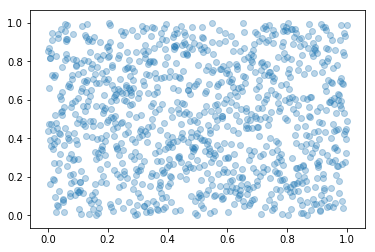

In [6]:
plt.scatter(hcube[:, 0], hcube[:, 1], alpha=0.3)

In [7]:
normalised_theta_df = pd.DataFrame(hcube, columns=free_params.keys())
normalised_theta_df.head()

,log_mass,dust2,tage,tau,log_agn_mass,agn_eb_v,log_agn_torus_mass
0,0.533927,0.385500,0.480726,0.853863,0.714900,0.782147,0.525791
1,0.025128,0.520597,0.731530,0.723868,0.460058,0.969374,0.976873
2,0.558017,0.517774,0.594298,0.017167,0.542950,0.823747,0.867866
3,0.133400,0.595868,0.809774,0.873433,0.309639,0.820299,0.897822
4,0.946617,0.600651,0.639172,0.362463,0.877179,0.180922,0.079421


In [8]:
denormalised_hcube = simulation_utils.denormalise_hypercube(hcube, free_params)

log_mass 8.001355860668259 11.999147137989066
dust2 0.01257689290918218 13.7912591502093
tage 0.0003229257880541938 1.9993909681676043
tau 0.1099508139241301 29.984264371805423
log_agn_mass -6.993415745957657 1.1702384187486423
agn_eb_v 0.00028593659857333324 0.49973245150543155
log_agn_torus_mass -6.9959077689565685 1.1715016131562255


In [9]:
theta_df = pd.DataFrame(denormalised_hcube, columns=[k.lstrip('log_') for k in free_params.keys()])
theta_df.head()

,mass,dust2,tage,tau,agn_mass,agn_eb_v,agn_torus_mass
0,1.366806e+10,5.320515,0.961453,25.630511,0.069998,0.391074,1.990267e-03
1,1.260412e+08,7.184713,1.463061,21.743640,0.000577,0.484687,9.705161e+00
2,1.706356e+10,7.145760,1.188596,0.613306,0.002749,0.411873,1.246670e+00
3,3.416646e+08,8.223382,1.619548,26.215641,0.000034,0.410150,2.191174e+00
4,6.116025e+11,8.289378,1.278345,10.937630,1.485592,0.090461,4.460149e-07


*Don't modify these!*

# Infer Observations

- Calculate observations with denomalised hypercube (i.e. param space)
- Show LFI hypercube -> observations

In [34]:
example_theta = theta_df.sample().squeeze().values
example_theta

array([8.75544155e+09, 3.37141968e+00, 4.58713229e-01, 2.41926266e+01,
       9.25555089e-05, 2.40431365e-02, 1.23280902e-07])

In [35]:
model_spectra, model_photometry, spec_wavelengths = visualise.calculate_sed(model, example_theta, obs, sps) 
phot_wavelengths = obs['phot_wave']

Text(0, 0.5, 'Observed Flux')

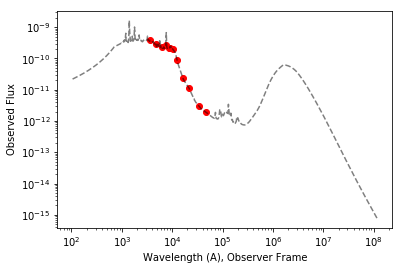

In [36]:
plt.loglog(phot_wavelengths, model_photometry, 'o', color='r')
plt.loglog(spec_wavelengths, model_spectra, 'k--', alpha=0.5)
plt.xlabel('Wavelength (A), Observer Frame')
plt.ylabel('Observed Flux')

In [24]:
def simulator(theta):
    print(theta)
    _, model_photometry, _ = visualise.calculate_sed(model, theta, obs, sps)  # via closure
#     phot_wavelengths = obs['phot_wave']  # always the same, as in observer frame
    return model_photometry

In [25]:
model.theta

array([2.53505943e+10, 4.14701013e+00, 3.61635270e-01, 5.55299647e+00,
       7.03377134e-01, 2.87867796e-01, 1.06463953e-07])

In [26]:
simulator(theta_df.iloc[0].values)

[1.36680564e+10 5.32051508e+00 9.61452672e-01 2.56305109e+01
 6.99977045e-02 3.91073736e-01 1.99026693e-03]


array([7.74079040e-08, 8.71880963e-08, 1.09592893e-07, 1.42872999e-07,
       1.32659559e-07, 2.99599543e-08, 7.34063520e-08, 2.97786777e-08,
       1.32711104e-07, 1.31903334e-07, 4.18503818e-08, 4.12479268e-08])

In [27]:
normalised_params, photometry = simulation_utils.sample(
    theta_df=theta_df,
    n_samples=n_samples,
    output_dim=12,
    simulator=simulator
)

2it [00:00, 16.38it/s]

[1.36680564e+10 5.32051508e+00 9.61452672e-01 2.56305109e+01
 6.99977045e-02 3.91073736e-01 1.99026693e-03]
[1.26041224e+08 7.18471309e+00 1.46306068e+00 2.17436400e+01
 5.77400168e-04 4.84686888e-01 9.70516075e+00]
[1.70635594e+10 7.14576003e+00 1.18859584e+00 6.13306420e-01
 2.74920798e-03 4.11873434e-01 1.24667029e+00]
[3.41664589e+08 8.22338213e+00 1.61954751e+00 2.62156409e+01
 3.40122920e-05 4.10149564e-01 2.19117433e+00]


6it [00:00, 12.79it/s]

[6.11602542e+11 8.28937826e+00 1.27834486e+00 1.09376302e+01
 1.48559212e+00 9.04608139e-02 4.46014896e-07]
[1.69554211e+11 9.03062649e+00 3.10344985e-01 1.67379654e+01
 1.63642134e-03 3.38708653e-01 2.68637597e-03]
[2.39458856e+10 2.11844519e+00 8.80386459e-02 1.01599653e+01
 9.89440646e-03 2.41372971e-01 5.46850726e-06]


8it [00:00, 12.78it/s]

[2.94087013e+08 7.84980006e+00 1.29582369e+00 1.59677774e+01
 9.40818180e-04 3.31760957e-01 1.52686481e-04]
[2.58244683e+11 3.63794892e+00 4.81692505e-01 1.03069994e+01
 1.41586923e-02 4.06901932e-02 1.72325662e+00]
[6.64469845e+11 4.80806403e+00 6.23263812e-01 7.33295012e+00
 9.85739385e-05 2.22957362e-01 1.35435397e-07]


12it [00:00, 14.20it/s]

[5.18222008e+10 1.11092778e+01 4.43141986e-02 3.10320297e+00
 1.28534833e+01 2.35562192e-01 5.79107709e-03]
[6.04748230e+08 5.76128774e+00 3.15949941e-01 2.32940949e+01
 4.14558605e-07 2.68321341e-01 1.89242930e+00]
[3.35263706e+08 9.72046470e+00 1.80104752e+00 1.82634660e+01
 1.76956262e+00 3.27990257e-01 1.60302190e-06]
[2.78733650e+08 8.92774799e+00 3.39368294e-01 2.09317012e+01
 6.70586202e-04 4.00907269e-01 4.73770862e-05]


16it [00:01, 16.11it/s]

[4.25510229e+10 1.31248489e+01 1.36568409e+00 5.47632951e+00
 3.47050428e-05 1.72434663e-01 4.82757282e-03]
[2.72910798e+09 4.47569492e+00 3.05971301e-01 2.75135075e+00
 4.59839534e-03 3.90134382e-01 2.91582093e-02]
[2.43192448e+11 1.27259603e+01 1.59639223e+00 2.47697448e+01
 4.56475539e-05 1.12690188e-01 1.40561248e-06]
[3.83689517e+08 1.49306808e+00 1.57322036e+00 6.98444387e+00
 3.06251348e-05 1.09755077e-01 1.03642525e-01]
[1.66843869e+10 4.50370966e+00 1.78040821e+00 2.94936123e+01
 7.69700677e-05 1.69573186e-02 3.67173018e-07]


21it [00:01, 17.33it/s]

[6.29483384e+09 1.21756028e+01 8.36764263e-01 2.01189242e+01
 7.27367348e-07 2.60909001e-01 1.24199275e-06]
[9.99654568e+09 3.97507581e+00 1.55313552e+00 4.11119613e+00
 1.92036297e-06 7.42238108e-02 1.23486077e-02]
[4.86715811e+08 9.48189706e+00 8.16167569e-01 2.78111877e+01
 1.04663225e-01 2.29576800e-01 5.17088216e-04]
[4.28118940e+11 5.45026403e+00 1.58520212e+00 2.87806872e+01
 6.49536859e-04 2.91038571e-01 5.37395128e-05]


27it [00:01, 19.32it/s]

[1.47295643e+10 5.87659069e+00 1.63700214e+00 2.30278290e+01
 1.19308792e-05 2.14322297e-01 7.37069383e-02]
[2.54103818e+11 1.59585807e-01 9.75843762e-01 1.76937637e+01
 3.80186590e-05 1.33459709e-01 1.44321535e+00]
[1.95294584e+10 1.32749586e+01 1.35392191e+00 1.15324876e+01
 2.10852832e-05 3.87644794e-01 7.66174213e+00]
[2.83810753e+08 1.35971814e+01 7.92042744e-01 1.63369033e+01
 2.12737343e-03 1.66646688e-01 4.37972249e-04]
[2.75935116e+08 1.24266964e-01 1.71738923e+00 2.98349911e+01
 3.40248706e-04 1.94522863e-01 4.91478430e-04]


30it [00:01, 19.67it/s]

[2.60366602e+08 1.66161395e+00 9.41857996e-01 7.05009326e+00
 5.27016100e-05 5.68678734e-03 9.96793001e-01]
[6.73022823e+11 8.41293203e+00 1.23957399e+00 2.49689687e+01
 1.00591006e-03 4.72467255e-02 6.24212169e-06]
[1.29036952e+09 4.28705429e+00 1.65109326e+00 2.89086180e+01
 2.69603051e-05 3.30528560e-01 1.29720555e-01]
[1.63714967e+08 5.03073005e+00 3.82878291e-01 1.79046132e+01
 3.17612341e-06 1.08897116e-01 1.22862289e+01]
[2.04197213e+10 9.54720444e+00 5.80403800e-01 1.77697824e+01
 1.47747281e-02 4.83579057e-01 8.24653059e-02]


35it [00:02, 18.22it/s]

[1.72720679e+09 6.03224554e+00 7.12040623e-01 2.25117722e+00
 7.10879462e-07 6.04616988e-02 5.92962058e-07]
[1.13636086e+08 1.00537917e+01 1.25443800e+00 2.55381667e+01
 7.06907854e-05 8.55637822e-02 2.96095786e-02]
[3.06167124e+10 4.42753481e+00 1.95916603e+00 1.39420346e+00
 4.62840286e+00 9.76179547e-02 1.66146373e-06]
[4.40115096e+10 7.47160017e+00 2.51173548e-01 3.23145403e+00
 7.41549333e-02 3.49479135e-01 4.78412882e-04]


39it [00:02, 18.39it/s]

[1.34729769e+11 1.21547251e+01 1.37462678e+00 1.34020916e+01
 2.99587918e+00 1.27213705e-01 2.16852094e-04]
[4.85953664e+11 1.85668662e+00 6.18112910e-01 9.69060119e+00
 3.13134898e-07 3.24366100e-01 1.39901653e+00]
[2.60370676e+10 9.59998504e+00 1.97762094e+00 2.32041012e+01
 1.52284822e-01 1.81659742e-01 3.39941755e-07]
[1.85231665e+11 1.33328444e+01 1.39436367e+00 1.40457805e+01
 5.58103247e+00 4.87742196e-01 3.89379866e-07]
[2.88381132e+11 9.84210817e-01 4.47249257e-01 1.62271890e+01
 3.41093315e-06 1.82244877e-01 3.85943412e-02]


45it [00:02, 19.53it/s]

[2.51169699e+11 7.46824792e-01 2.25095577e-01 1.56575900e+01
 1.62371801e-06 3.33270012e-01 4.40120933e-02]
[2.91021809e+08 6.54636586e+00 4.95028834e-01 1.80930626e+01
 3.17861387e-05 1.18172402e-01 6.45233758e-01]
[2.23658829e+10 8.03762590e+00 7.16213806e-01 2.84732490e+01
 3.05963864e+00 2.09713989e-01 4.24393290e-03]
[7.39897898e+11 4.71700975e+00 1.20071752e+00 9.53132560e+00
 9.92434109e-03 4.68906438e-01 1.04855370e-05]
[5.91128438e+08 1.03712590e+01 7.70978145e-01 2.86820214e+01
 5.46282404e-01 8.64660903e-02 2.20295028e-02]


50it [00:02, 19.12it/s]

[1.27113436e+08 1.14482524e+01 4.45913169e-01 1.28741398e+01
 1.64842776e-02 4.56065670e-01 1.80900085e-02]
[9.84662322e+10 9.99142050e+00 6.63063823e-01 1.17039119e+01
 1.24059529e+01 4.04015732e-01 1.12378220e-07]
[2.29448370e+09 2.07465529e+00 1.83577837e+00 2.08557521e+01
 5.38168061e-04 1.03692956e-01 6.69335851e-01]
[6.98454941e+10 1.10950718e-01 1.18110223e+00 2.77625302e+01
 1.90903572e+00 4.11135872e-01 5.20845394e-03]


52it [00:02, 17.09it/s]

[4.70447083e+10 1.13206168e+01 7.04544397e-01 1.33439508e+01
 1.29560719e-05 5.46972130e-02 2.74589331e-02]
[5.58543275e+09 4.26483602e+00 3.42427492e-02 2.43252405e+01
 1.22481235e-07 4.92084942e-01 2.39011367e-06]
[1.73954306e+08 1.26028864e+01 4.03047941e-01 1.05218183e+01
 1.20620096e+01 1.72895503e-01 1.79405595e-03]


57it [00:03, 17.60it/s]

[4.75940815e+11 2.68721302e+00 1.64502306e+00 2.01706229e+01
 1.81858910e-04 3.64372603e-01 1.41725205e-02]
[2.36060542e+08 1.07629093e+01 5.79109918e-01 3.68483555e+00
 2.49450806e-04 1.59032981e-01 1.94899939e-03]
[5.39344608e+11 1.10276924e+01 6.44500030e-01 3.24442880e+00
 5.70962408e-02 1.43051317e-01 5.17822200e-06]
[5.92642602e+11 8.09932555e+00 1.41386518e+00 1.00150131e+01
 2.22861396e-05 3.58512992e-01 4.69052099e-04]
[4.21844678e+11 6.69541534e+00 4.79458010e-01 2.41038943e+01
 4.44835405e-06 4.67043378e-01 3.43908389e-05]


61it [00:03, 15.69it/s]

[3.02343201e+10 6.12587582e+00 1.05613399e+00 7.14333292e+00
 1.68882839e-07 1.73417780e-01 3.28687585e-02]
[5.60011155e+08 7.52280867e+00 1.78554211e+00 1.14338495e+01
 5.11699121e-03 5.21032790e-03 3.98658275e-01]
[1.72017177e+09 3.28499837e+00 5.50410179e-01 1.54265826e+01
 4.39657326e+00 6.42720723e-02 3.44713985e-02]
[4.64731247e+09 5.28951226e+00 1.05417543e+00 2.42854142e+01
 1.47679792e-04 1.57572629e-01 6.99568626e-01]


65it [00:03, 16.53it/s]

[2.71630704e+09 7.38032989e+00 1.68288287e+00 2.84895132e+01
 1.91339241e-07 4.52448557e-01 1.24447803e-04]
[5.92539240e+10 1.02521694e+01 1.68197317e+00 2.51145995e+01
 1.40277528e-07 1.29189912e-01 7.07367973e-07]
[1.52419606e+09 1.17033944e+01 4.31795531e-01 9.76517212e+00
 3.25130838e-04 4.13864416e-01 6.63735571e-03]
[1.57457669e+09 1.28667853e+01 1.50748184e+00 1.66167822e+01
 7.05625383e-04 3.35714911e-01 1.19419098e+01]


70it [00:03, 16.51it/s]

[2.05775605e+10 1.04560866e+01 3.62347487e-01 2.49042213e+01
 9.71824060e-07 4.07371857e-01 9.30329876e-07]
[1.55128606e+11 1.13354223e+01 1.69896530e+00 5.68964985e+00
 2.51798601e-06 3.67935815e-01 1.29132001e+01]
[2.08332302e+11 3.40295545e+00 1.90141951e+00 1.43765595e+01
 2.17506841e-07 1.83490903e-01 9.76855858e-03]
[1.49621890e+11 8.25376359e+00 1.66317676e+00 9.36881218e+00
 1.76651467e-06 4.22316446e-01 1.70668915e-07]


74it [00:04, 16.59it/s]

[2.31573672e+09 1.10538807e+01 1.87296942e+00 4.10244011e+00
 2.16542848e+00 3.53435892e-01 1.37763600e-03]
[1.73599237e+08 1.15808462e+01 1.08814576e+00 6.80882024e-01
 3.13732986e-05 3.79378996e-01 1.18978563e-07]
[4.70295441e+09 3.68003055e+00 1.32220922e+00 2.92971659e+01
 9.20858329e-02 4.38067044e-01 9.27734094e-03]
[6.52192155e+08 1.18156982e+01 1.44947690e+00 2.47382148e+01
 3.58962924e+00 4.08910582e-01 1.36211331e-03]


78it [00:04, 16.96it/s]

[1.70252892e+10 7.94157250e+00 8.11098638e-01 2.78708021e+01
 9.28882007e-07 5.75765322e-02 1.70753783e-05]
[2.12284949e+09 5.83834574e+00 1.51741014e+00 2.63945109e+01
 7.27085965e-03 3.48480614e-01 6.62438847e-05]
[9.40532933e+09 1.41653244e-01 1.24315425e+00 2.24807344e+01
 3.32385456e+00 4.39729787e-01 5.39032424e-04]
[1.12910709e+09 1.05766617e+01 1.95695942e+00 8.07398698e+00
 4.13453598e-01 8.89989679e-02 3.07266749e-03]


82it [00:04, 17.14it/s]

[4.89933386e+10 7.68332592e-01 7.35422088e-01 1.55645914e+01
 1.04486365e-03 2.51249209e-01 1.65362064e-04]
[3.69657420e+09 1.19027594e+01 2.63318311e-01 2.41364136e+01
 2.97592590e-05 1.85420903e-01 2.57117618e-01]
[1.05693523e+10 7.17506701e+00 1.57808717e+00 2.60727294e+01
 4.39982112e-02 1.44540360e-01 3.34619852e-01]
[1.94005490e+11 1.27870396e+01 1.19675387e+00 2.53391145e+01
 6.09287058e-03 4.61897144e-01 2.51291609e-07]


86it [00:04, 16.43it/s]

[5.06213800e+09 1.20350963e+01 8.41067744e-01 7.93645924e+00
 2.09139124e-03 2.45304128e-01 3.51922333e-01]
[7.42705792e+08 6.18385922e+00 3.25776129e-01 1.47027376e+01
 2.89623131e-07 4.06464804e-01 1.00489258e-02]
[1.31955917e+09 1.05498982e+01 8.62353322e-01 2.58838679e+01
 1.38637796e-01 1.20393280e-01 2.57506234e-06]
[3.08944909e+09 1.22788106e+01 9.00284024e-01 1.53497675e+01
 1.26571619e+00 4.82841808e-01 7.00634712e-04]


90it [00:05, 17.96it/s]

[9.07507502e+10 1.36254716e+01 1.02577391e+00 8.10107862e+00
 3.69091415e-03 3.88998346e-01 3.88196656e+00]
[7.12984249e+11 6.12856236e+00 6.53139135e-01 1.69683222e+01
 3.20795462e+00 6.10968911e-02 2.80877252e-02]
[1.60191845e+08 1.07247313e+00 1.14285613e+00 1.26247197e+01
 5.51556849e-05 4.09678282e-01 2.17944288e-07]
[3.73423588e+09 6.20656454e-01 1.64953806e+00 4.88339753e+00
 1.52613293e+00 3.20050301e-01 1.05782534e-04]


94it [00:05, 18.31it/s]

[4.56267513e+11 6.62532607e+00 1.11240958e+00 2.61646091e+01
 1.04034692e-06 3.25830615e-01 1.34179838e-06]
[3.13057788e+08 1.29459702e+01 9.34319493e-01 7.59711004e+00
 9.50933079e-01 4.85798883e-01 3.83698862e-06]
[3.08049042e+11 7.75838700e+00 4.93019130e-01 1.11827887e+01
 2.58007428e-02 9.88221216e-02 1.28289272e-07]
[6.91125949e+10 6.88841462e+00 1.47171719e-01 1.47270514e+01
 1.35441091e-05 2.34417299e-02 6.50781048e-04]


98it [00:05, 18.92it/s]

[4.09883631e+11 1.26786383e+01 6.93797829e-01 3.04076543e+00
 3.98948647e-05 4.89703538e-01 1.85764709e-05]
[2.55461431e+08 1.67169829e+00 2.93277569e-01 2.44541002e+01
 9.10040814e-06 2.99699336e-01 5.59780017e-07]
[3.13840514e+10 1.69030218e+00 2.24374216e-02 1.68216310e+01
 9.55237749e-03 3.52896842e-01 1.30398491e-04]
[1.81507420e+10 5.06462375e+00 1.86127323e+00 9.03226788e+00
 1.85934144e+00 2.52638189e-01 3.74871983e-06]


100it [00:05, 17.72it/s]

[3.59245400e+08 1.09239055e+00 1.06718784e+00 6.49019820e+00
 1.00844928e+01 2.24189275e-01 7.17492780e-04]
[3.53059069e+11 1.17382594e+00 1.25696851e+00 1.95338335e+01
 1.55256814e-01 2.77743575e-01 2.87007674e-04]
[1.58218555e+08 9.68915849e-01 1.98636575e+00 1.48633415e+01
 6.32652315e-03 2.73928796e-01 1.20041745e-05]
[4.45236158e+09 7.57548554e+00 4.42796871e-01 1.61220434e+01
 2.18918750e-01 4.87300839e-01 3.20792981e-03]


105it [00:05, 18.69it/s]

[1.98398293e+10 4.77064265e+00 1.51597956e+00 8.92761832e+00
 5.93860780e-01 4.42612878e-01 2.03784089e-04]
[1.33066042e+09 7.95491702e+00 1.12008234e+00 5.89963598e-01
 1.80864291e-01 4.51984085e-01 2.60843648e-03]
[1.55298301e+09 7.25435945e-01 7.45656946e-02 6.62535833e+00
 1.24877957e-05 4.93788630e-01 1.86879916e-07]
[4.69762833e+09 1.27558513e+01 2.74570211e-01 6.85484471e+00
 4.55782382e+00 7.70815783e-02 4.14266986e-07]
[1.77191985e+10 1.09907222e+01 1.05315822e+00 4.14082520e+00
 4.17814563e-05 2.59283741e-01 3.07526442e-07]


110it [00:06, 19.19it/s]

[7.12933855e+09 2.63428624e+00 1.97420068e+00 2.24020336e+01
 1.34334684e+00 4.17160821e-02 3.47540860e+00]
[3.62012918e+11 1.19315575e+01 1.17870783e+00 4.46394476e+00
 9.42264688e-04 3.59790273e-01 6.80860883e-01]
[1.68783657e+11 8.38471224e+00 1.03552831e+00 1.94193507e+01
 1.54379509e-02 6.98010772e-03 3.40570424e-04]
[3.32381566e+10 7.21424962e+00 4.56532703e-01 2.28533520e+01
 1.54063700e-05 1.16622531e-01 1.57772940e-06]
[1.69878015e+08 6.27860905e+00 1.53487226e+00 2.90441671e+01
 3.93846503e-01 3.29954482e-01 1.15400160e-03]


115it [00:06, 17.79it/s]

[6.57789302e+10 9.68613418e+00 1.19035868e+00 4.17172023e+00
 2.42867859e+00 3.85917334e-01 4.23067173e-07]
[8.57353922e+10 8.60784543e+00 1.57272382e-01 2.48382514e+01
 8.02384823e-01 4.40372274e-01 2.29684774e-03]
[2.32004664e+10 1.30823071e+01 1.84596186e+00 6.70574681e+00
 2.32934902e-07 2.12394256e-01 1.92161532e-07]
[8.75544155e+09 3.37141968e+00 4.58713229e-01 2.41926266e+01
 9.25555089e-05 2.40431365e-02 1.23280902e-07]


119it [00:06, 15.73it/s]

[1.78846614e+09 2.22054180e+00 1.16078896e+00 1.90987122e+01
 5.17880901e-07 3.05664501e-01 5.90552624e+00]
[1.38616497e+11 3.60025208e+00 1.81093762e+00 1.84176868e+01
 7.48695102e-01 1.49311082e-02 7.88969142e-07]
[4.45284569e+11 8.58820255e-01 5.10478109e-01 4.00033332e+00
 2.27916213e-01 2.52374133e-01 1.61841001e-03]
[8.46639032e+09 1.34714336e+01 1.64007003e-01 7.87760418e+00
 1.33959125e-01 4.31866310e-01 2.04601651e-03]


123it [00:07, 15.75it/s]

[1.18561038e+11 1.13462226e+01 1.76593288e+00 1.73369659e+00
 9.84378976e-06 1.07035259e-01 1.57176716e-05]
[2.30637669e+11 2.44891298e+00 1.10925258e+00 2.25485679e+01
 4.14897223e+00 2.96944533e-01 1.40832455e-05]
[8.68904389e+10 6.45885411e+00 1.25089875e+00 3.85841210e-01
 2.92394661e-05 2.20426512e-02 8.04936468e+00]
[4.07984486e+11 3.64526189e+00 1.48395788e+00 2.47701570e+00
 2.17361648e-02 1.35312873e-01 1.09164726e-07]


127it [00:07, 15.91it/s]

[2.14029303e+08 3.97626603e+00 1.83161570e+00 1.61887035e+01
 5.79412063e-07 4.43946605e-01 1.25248123e+01]
[2.44668123e+11 6.97713949e+00 1.49630316e+00 1.83919753e+01
 1.05294980e+01 3.46481046e-01 6.62720859e+00]
[7.73000692e+08 5.67968115e+00 1.93934555e+00 1.94333007e+00
 1.57083139e+00 1.59987483e-01 3.56210233e-02]
[1.00568584e+10 9.62088792e+00 1.39242581e+00 1.69411905e+01
 8.35310468e-02 7.86312190e-03 8.62391815e-02]


131it [00:07, 14.26it/s]

[2.34446908e+09 2.23244559e-01 5.96048428e-02 8.56321193e+00
 7.96534108e-06 2.85936599e-04 1.79725732e-05]
[3.56435357e+11 8.19968076e-01 1.16542211e+00 3.78989577e+00
 5.06370520e-04 3.57669025e-01 4.62650247e-05]
[3.78957805e+09 1.25670428e+01 1.66733084e-01 1.53861598e+01
 2.72640456e-06 3.31029663e-01 3.05917651e+00]


135it [00:07, 14.89it/s]

[2.56169463e+09 1.10646222e+01 4.52399061e-01 2.59394586e+01
 4.98620372e-01 4.52758376e-01 2.23379023e-02]
[1.03155709e+08 9.09729903e+00 3.18133907e-01 1.11255719e+01
 2.49252901e+00 4.15003840e-01 2.21818826e-06]
[1.59046479e+11 1.91355710e+00 5.19425784e-01 1.23936691e+01
 1.46431087e-02 1.90729446e-01 4.90364460e-02]
[4.69264275e+08 4.49643199e+00 4.78680607e-02 2.09649611e+01
 8.85726847e-05 1.16043345e-01 5.33228342e-02]


137it [00:08, 13.57it/s]

[9.81745735e+10 4.53643882e+00 2.80216630e-01 2.38025238e+01
 8.22875986e-05 1.18518012e-01 1.43796094e-04]
[4.86083643e+09 1.21384962e+01 7.77102155e-01 4.33385186e+00
 2.17967513e-04 3.46638231e-01 5.37975680e+00]
[4.12077767e+09 3.57866746e+00 7.50049486e-01 4.61280501e+00
 5.24274831e-01 3.06338558e-01 8.60366781e-05]


139it [00:08, 14.38it/s]

[1.85717074e+10 7.55866161e+00 1.77280440e+00 4.90507250e+00
 2.36673388e-04 1.12285715e-01 3.93824489e-02]
[3.73379218e+08 9.01643439e+00 1.27772179e+00 2.69969313e+01
 7.20221999e-06 2.80915524e-01 2.45923864e-04]


143it [00:08, 11.47it/s]

[1.13343016e+11 1.05342716e+01 5.34162115e-01 1.42217326e+01
 1.30232526e+00 4.58959985e-01 3.08835577e-01]
[3.47470334e+10 5.93571190e+00 7.18784174e-01 2.74278422e+01
 9.26261501e-01 4.82284694e-01 3.57562495e-03]
[1.52468513e+10 7.50995216e+00 5.17703692e-01 1.93835595e+01
 4.06227201e-01 1.34098905e-01 1.22106394e-04]


147it [00:08, 12.92it/s]

[2.40111883e+11 1.80852512e-01 5.83360527e-01 2.15063722e+01
 2.78638683e-01 2.59699650e-01 2.39676082e-07]
[3.81753505e+10 2.15573836e+00 1.37658663e+00 2.72347249e+01
 1.99509377e-06 1.19237162e-01 1.35297936e-04]
[7.57147632e+10 1.34353187e+01 1.86825934e+00 1.17297154e+00
 2.49532939e-06 2.58146138e-01 1.49124698e-04]
[1.12766076e+10 7.37238787e-01 1.62817370e+00 1.32987838e+01
 3.11642522e-01 3.92007374e-01 2.63644631e-06]


149it [00:08, 13.60it/s]

[5.73488720e+08 5.30622753e+00 8.00521356e-01 8.02383024e+00
 3.79596196e-01 2.70163517e-01 4.24075467e+00]
[2.32082283e+08 1.44752402e+00 2.89705124e-02 1.19851209e+01
 1.23560530e-03 1.30825010e-01 2.24733480e+00]
[2.76632897e+10 1.28399258e+01 1.92553783e+00 1.59179132e+01
 1.67477104e-01 3.25330408e-01 5.85930086e-07]


153it [00:09, 12.11it/s]

[5.10069994e+10 9.21591662e-01 1.40510931e+00 2.58722941e+01
 2.68446486e-02 3.98547850e-01 6.83911655e-04]
[3.87481039e+09 5.75092515e+00 3.87372509e-01 1.02748838e+01
 2.01543250e+00 6.25309085e-03 1.06045939e-02]
[2.72330720e+11 6.43374559e+00 1.33434064e+00 1.06253448e+01
 3.40510648e-07 1.00117078e-01 1.07050456e-03]


157it [00:09, 14.34it/s]

[1.39848769e+11 1.32149913e+01 1.96982608e+00 2.91351995e+00
 1.01901524e-03 3.07741305e-01 2.91989391e-01]
[2.98394172e+09 3.53625914e-01 1.40808704e+00 4.97320395e+00
 3.31540203e-07 3.40665089e-01 1.16056892e-04]
[2.86602455e+08 9.09367798e+00 1.85163869e+00 1.77898309e+01
 3.71869741e-05 3.38357077e-01 3.68526924e-04]
[1.53687869e+11 1.34908986e+01 3.22185924e-01 1.29264386e+01
 1.76875675e-01 4.06587589e-01 1.48423139e+01]


161it [00:09, 16.70it/s]

[2.91102120e+10 2.06808576e+00 1.15043009e-01 2.14243874e+01
 4.35045716e-01 1.46634742e-01 3.41590070e-03]
[8.41581294e+11 9.84360273e+00 1.42802046e+00 2.30858404e+01
 2.50994886e-02 2.37816573e-01 6.35127615e-06]
[7.56824419e+08 3.23306596e+00 1.73241547e+00 2.26528263e+01
 1.17053651e+01 3.64785791e-01 2.73330751e-07]
[3.16253527e+08 2.64750758e+00 3.75123411e-01 2.89342255e+01
 1.22906181e-06 1.10651731e-01 8.35015579e-06]
[1.19785184e+11 5.22137455e+00 1.41912355e+00 2.40072174e+01
 1.26314695e-03 2.08260083e-01 9.01891566e-07]


165it [00:10, 17.30it/s]

[2.17975047e+09 6.32967266e+00 1.15641921e+00 1.04190058e+01
 2.33781104e-03 3.80480280e-01 1.55121030e-05]
[2.40046428e+08 1.11510960e+01 1.86543503e+00 1.27899909e+01
 4.43323697e-05 1.52436517e-01 1.01194840e-06]
[2.05510075e+11 5.20772180e+00 7.90024670e-01 2.82675279e+01
 7.28227098e+00 4.05189475e-01 1.87170532e-01]
[3.94314922e+08 1.24724591e+01 1.63461837e+00 9.40434800e+00
 3.23235465e-02 2.86753818e-01 4.86404812e-07]


169it [00:10, 16.98it/s]

[3.32687147e+09 1.26270427e+01 1.93725677e-01 5.52363299e+00
 1.21944008e-02 4.23749588e-02 5.85925936e-05]
[7.60649104e+09 9.30871893e+00 9.66382275e-01 9.75494743e+00
 1.99140548e-03 2.10472709e-01 2.95123514e+00]
[9.12116800e+09 6.81708237e+00 1.28813040e+00 6.77487624e+00
 5.09415870e-06 2.83479894e-01 1.01365789e+01]


173it [00:10, 17.12it/s]

[1.94404914e+09 6.43234225e-01 1.22741876e+00 1.89185259e+01
 2.84158099e-01 4.14582499e-01 9.74719147e-02]
[1.47310899e+11 7.00592577e+00 2.95670080e-01 1.65831012e+01
 6.40191992e-01 1.50075296e-01 5.55841909e-01]
[7.52681173e+11 3.51917595e+00 1.88317039e-01 1.34807109e+01
 1.12028303e-06 2.80145728e-01 3.64655890e-03]
[2.17146975e+10 1.22193419e+00 1.03353121e+00 2.34364372e+01
 1.25455844e-06 3.09867256e-01 2.30738796e-05]
[2.88277648e+10 9.73801368e+00 5.65288849e-01 1.07348923e+00
 3.10916863e-06 1.24605687e-01 3.73299288e-05]


178it [00:10, 17.73it/s]

[3.02653299e+09 4.58010108e+00 4.27120777e-01 1.31630469e+01
 1.42855668e+00 1.35882892e-01 2.69408382e-07]
[3.96514376e+10 8.91018403e+00 8.09194095e-01 2.44248402e+01
 5.22858739e-06 3.19994556e-02 2.85561528e-02]
[4.03245985e+11 6.07288839e+00 2.01851432e-03 1.30759736e+01
 9.09105619e+00 4.18463393e-01 7.27531022e-05]
[3.46101417e+11 1.23159059e+01 6.29162588e-01 1.45347907e+01
 3.17626274e-03 4.66979800e-01 8.97144531e-05]


183it [00:11, 19.05it/s]

[1.10467683e+08 6.53000920e+00 6.13259353e-01 9.49011110e-01
 8.94781097e-02 3.94028976e-01 1.68671093e-02]
[3.66094264e+11 6.00041160e+00 8.96438112e-01 2.39134534e+01
 3.15733016e+00 1.05008776e-01 3.70826563e-03]
[1.15151142e+10 1.27950950e+01 5.68785407e-01 1.20101787e+00
 3.62633945e-04 2.66994572e-01 1.34182178e-03]
[2.37225272e+10 1.02150335e+01 1.40690759e+00 2.02808167e+01
 1.11614341e-01 8.14120737e-02 9.17573329e-05]
[1.07900606e+08 1.12634627e+01 1.08555076e+00 2.56707927e+01
 2.34040776e-05 1.69001333e-01 8.62122231e-06]


188it [00:11, 19.65it/s]

[1.06663793e+11 5.43228065e-01 3.28029806e-01 8.85660136e+00
 1.29404016e-01 1.95955039e-01 3.51951320e-07]
[2.07924972e+09 2.73360392e-01 1.04287537e+00 2.01565754e+01
 4.76821413e-05 7.68803021e-02 3.10192768e-04]
[4.36242890e+11 3.44563187e-01 5.58786827e-01 1.01154012e+01
 1.43211776e-03 1.75776914e-01 3.55426228e-04]
[1.80894707e+09 1.35921420e+01 1.51213336e+00 1.79204677e-01
 7.82236664e-01 2.76633568e-02 3.37743723e-06]
[1.16493068e+08 4.72473242e+00 1.99626609e+00 2.48032398e+01
 6.02826216e-05 3.13818908e-01 1.98053787e-04]


193it [00:11, 19.09it/s]

[1.10933332e+09 9.17683999e+00 1.91378868e+00 1.50533877e+01
 5.65446465e-02 2.15924191e-01 1.19179419e-05]
[1.01094004e+09 4.70257234e+00 1.11121457e+00 2.64873398e+01
 4.24385462e-05 4.46595200e-01 1.30464086e-07]
[4.31320895e+11 7.74516414e+00 7.61157091e-01 1.51256414e+01
 8.05971677e-03 4.64162914e-01 3.31122930e-07]
[2.66016632e+10 1.01627325e+01 1.36338723e+00 9.49105885e+00
 7.71025313e-03 1.82972359e-01 2.35707221e+00]
[1.55777693e+11 6.85687430e+00 1.79140265e+00 1.87057385e+01
 1.14187401e+00 4.02024142e-01 3.47977170e-03]


198it [00:11, 19.41it/s]

[7.84958208e+11 1.61701893e+00 6.78100975e-01 2.81656168e+01
 4.42640973e-07 4.19044045e-01 2.09118801e-06]
[1.54424850e+10 2.15028901e+00 1.96757827e+00 8.91838496e+00
 4.05777777e-06 2.30225393e-01 4.42150195e-07]
[8.44775538e+08 2.93340894e+00 1.05049433e+00 1.81088720e+01
 2.20874139e-05 1.96941104e-01 9.43908871e-05]
[2.53734009e+10 2.11618958e-01 5.04861855e-01 2.66577240e+01
 5.88937574e-06 3.36104045e-01 1.97602468e-02]


200it [00:11, 19.31it/s]

[4.09764005e+08 1.27457083e+01 1.29633836e+00 2.81323176e+01
 6.99852393e-07 3.67067166e-01 6.17477458e-04]
[1.12056029e+08 1.25853478e+01 1.30281961e+00 4.62591008e+00
 8.66597349e+00 2.55139537e-01 8.20167165e-03]
[4.62826598e+11 1.03097012e+01 8.12982672e-01 2.31007585e+00
 6.49451211e-01 1.78362988e-03 2.35313313e-03]
[9.69501008e+11 6.21283943e+00 8.39219304e-01 1.00554713e+01
 1.01685874e+00 3.58442619e-01 1.10831077e-01]
[2.01082925e+10 2.13211021e+00 9.54654043e-01 7.92631626e+00
 1.52342702e-04 3.16619854e-01 8.36257959e+00]


206it [00:12, 19.88it/s]

[1.48107655e+08 7.40347555e+00 1.10012570e-01 8.74696839e+00
 1.66254583e-06 2.10588565e-02 3.74802111e-02]
[1.90554544e+10 8.53870567e+00 1.51038287e+00 2.88774428e+01
 1.05179647e+00 2.05363158e-01 4.39325274e-05]
[1.34787858e+09 5.50289339e+00 3.09980125e-01 1.41378704e+01
 4.66945200e-07 3.50577216e-01 7.60680930e-04]
[1.93504907e+10 3.75960310e+00 2.15454788e-01 2.83235968e+01
 4.93590871e-04 2.23605750e-01 4.19605113e-06]
[1.43935273e+09 1.03382991e+01 1.38198128e+00 2.78901947e+01
 6.42044047e-04 3.75609449e-02 7.58687802e-06]


211it [00:12, 19.91it/s]

[3.42612863e+10 8.58295021e+00 1.84157508e+00 6.96148531e+00
 2.59042005e-07 5.54888989e-02 1.09008892e+01]
[2.83554484e+11 5.79640717e+00 1.38738351e+00 1.70869542e+01
 1.89805489e-04 2.33246077e-01 2.70775001e-01]
[2.91810603e+09 3.87810917e+00 1.51638727e-02 2.34810825e+01
 1.30699876e-07 4.57190063e-01 1.45814988e-07]
[1.42894415e+09 2.37972538e+00 7.55468736e-01 1.67828869e+01
 7.40352688e-05 3.41008867e-01 4.82352907e-06]
[1.40143644e+10 6.46834723e+00 1.45945539e+00 1.32062271e+01
 4.83940757e-05 4.35811644e-01 2.01080638e-02]


215it [00:12, 19.48it/s]

[2.23861537e+09 1.10088482e+01 6.24184837e-01 2.98053253e+01
 2.15157123e-07 4.61111474e-01 6.72832098e-02]
[3.96359824e+09 1.13825791e+01 1.70893292e+00 2.99098988e+01
 3.93785369e-03 4.46350231e-01 1.53237911e-02]
[1.86031442e+11 1.39966028e+00 1.30685375e+00 9.25176514e+00
 1.22182570e-06 2.08786579e-01 1.61806903e-07]
[3.69318468e+11 1.20816276e+01 1.09433741e+00 5.08702599e+00
 1.41972109e-01 3.66471429e-01 1.03479616e-05]


219it [00:12, 19.00it/s]

[3.39089291e+10 1.05081422e+01 6.61839939e-01 2.85183107e+01
 1.38498258e-04 4.29274246e-02 7.31504341e-01]
[5.49838685e+08 1.14854915e+01 1.77682990e+00 3.54833965e+00
 3.53179086e-05 4.16389251e-01 1.84439144e-04]
[1.93801270e+08 5.38760792e+00 1.61260417e+00 2.14646116e+00
 3.65724654e-05 1.59452625e-02 4.06842750e-05]
[8.33513037e+08 6.36293658e+00 1.32122963e+00 1.04502350e+01
 2.46318852e-05 2.57416691e-01 1.72655613e-03]
[6.37970538e+09 5.49011572e+00 1.01841481e+00 3.02589544e+00
 1.37834184e-05 2.92650297e-01 1.51897659e-03]


224it [00:13, 19.34it/s]

[6.13183971e+08 6.71279223e+00 1.36959112e-01 2.79948706e+01
 7.53193964e-05 1.54811702e-01 1.90426480e-05]
[1.56264926e+09 1.35398292e-01 1.46904926e+00 2.61906976e+01
 5.74864852e+00 2.18718731e-01 5.99070885e-02]
[1.83336746e+11 4.11416059e+00 7.11006650e-01 2.31584891e+01
 8.21613932e-06 4.57922010e-01 8.07902609e-03]
[3.43611958e+09 4.72709271e-01 6.84257149e-01 1.70820791e+01
 3.05220239e-06 3.22343155e-01 9.36908791e+00]


228it [00:13, 15.90it/s]

[9.43536033e+11 6.01572819e+00 1.80256567e+00 1.39434234e+01
 1.96852119e-05 4.79918210e-01 6.61380065e-04]
[2.43287978e+09 6.91370178e+00 1.50244282e-01 1.37150825e+01
 2.51317787e+00 4.63809296e-02 1.31083733e-02]
[5.35688605e+08 4.98541725e+00 1.36033703e+00 2.89794071e+01
 1.28676151e-03 3.39454649e-01 1.26604459e-07]
[7.30085480e+11 1.07762645e+01 6.77391006e-02 1.48780273e+01
 8.84415366e-01 1.77333609e-01 1.73457054e-06]
[2.82315023e+09 2.91769128e+00 1.28388222e+00 2.24589438e+01
 4.56798078e-02 1.53447473e-01 2.22983900e-04]


231it [00:13, 15.47it/s]

[6.45616522e+10 6.35951477e+00 2.09536614e-01 2.54361614e+01
 6.38572864e-06 3.12767333e-01 4.10078313e-02]
[2.53271026e+08 8.42468736e+00 1.14917582e+00 2.03670379e+01
 4.77170714e-01 2.97871870e-01 1.64630623e-03]


233it [00:13, 11.48it/s]

[3.17748289e+09 2.39261708e+00 1.52783088e+00 2.30357080e+01
 3.63065381e-01 2.35145498e-01 3.98294312e-06]
[2.01435945e+09 1.15950608e+01 1.70178582e-01 3.50258003e+00
 1.33470108e-03 1.70291379e-01 1.64584745e+00]


237it [00:14, 10.51it/s]

[3.55187261e+08 8.32719541e-02 4.64101064e-01 2.18835484e+00
 1.73899868e-02 1.40613504e-01 7.61573746e-01]
[1.22630717e+08 9.92462791e+00 8.74242257e-01 1.52684283e+01
 1.63975270e-05 1.11808357e-02 8.61236019e-04]
[1.72772637e+11 9.90947590e+00 4.89881979e-01 2.12098694e+01
 3.95212084e-02 1.97098876e-01 2.05315357e-07]


239it [00:14, 10.28it/s]

[2.59407718e+09 1.19798149e+01 1.99538508e+00 5.10534189e+00
 3.62831669e-02 3.47259206e-01 6.13006831e-06]
[1.98691090e+11 5.78026917e+00 6.15803267e-01 5.22194175e+00
 7.71803169e-07 2.81650871e-01 3.19076802e+00]
[1.47081632e+11 1.32599874e+01 6.90164001e-01 1.40711912e+01
 5.98523107e-05 4.53930956e-01 4.12876205e-04]


243it [00:14, 11.04it/s]

[5.17197699e+11 8.93244178e+00 8.89627416e-01 1.68922874e+00
 1.50414240e-02 2.03889296e-01 8.17515837e-06]
[7.99184346e+11 9.65180144e+00 5.54385217e-01 8.36960977e+00
 3.07050025e-03 4.24273879e-01 2.66317204e-04]
[2.69455621e+08 2.42911428e+00 6.59404642e-01 1.92560959e+01
 1.15464736e-07 3.94371116e-02 2.55039715e-04]


245it [00:15, 11.51it/s]

[4.82230722e+10 4.67063557e+00 1.16738405e+00 1.71511639e+01
 4.90816079e-03 2.69696071e-01 4.74060231e+00]
[7.24170487e+10 1.26959408e+01 1.11535313e+00 2.12971919e+01
 2.26391435e-07 4.60020366e-01 1.46636277e-04]
[8.57711961e+09 1.28128604e+01 5.53359466e-01 2.97333689e+01
 6.24087213e-06 2.82026971e-01 5.86242409e-01]


249it [00:15, 13.56it/s]

[1.35448408e+10 5.08514566e+00 1.02600699e+00 2.05142383e+01
 1.49624216e-01 3.18536068e-01 5.76489769e-06]
[1.76210634e+11 1.33851188e+01 1.24787465e+00 2.55301787e+00
 2.42147879e-01 1.37832326e-02 5.46193774e-02]
[6.85702617e+11 3.99525426e+00 1.59859409e-01 2.40316592e+01
 7.71389391e-01 5.40828139e-02 9.06281158e-01]
[1.90461424e+09 9.34612924e+00 1.93011091e+00 1.98819856e+01
 1.47992061e+01 3.34589534e-01 2.06965980e-06]


253it [00:15, 15.48it/s]

[3.38430534e+09 7.97648945e+00 1.53381349e+00 1.78356665e+01
 1.51854522e-03 1.95311549e-01 2.02074923e+00]
[4.55589512e+10 2.26698184e+00 1.00445209e+00 2.63185113e+01
 5.15967157e-05 1.63576998e-02 5.30490139e-01]
[4.52248641e+10 6.49298384e+00 6.88190761e-01 2.06111207e+01
 1.60077559e-03 4.50552397e-01 3.51251756e-06]


255it [00:15, 13.77it/s]

[6.55577825e+08 1.37912592e+01 1.43494160e-01 1.20377489e+01
 1.69225201e-02 6.88868072e-02 1.37907343e-02]
[2.61615670e+08 6.88326271e+00 2.11317929e-01 1.89915532e+01
 3.47106238e-03 2.79743758e-01 4.82502022e-05]
[2.75326657e+08 1.09150464e+01 7.59919604e-01 2.37734114e+01
 5.15801281e+00 2.00620045e-01 1.61001254e+00]


259it [00:15, 15.27it/s]

[8.80551426e+10 1.00716921e+01 1.53663879e-01 4.66776640e-01
 3.02517559e-07 2.40579775e-01 2.73895382e-03]
[3.51595923e+08 1.26344277e+01 1.40199838e+00 4.68849168e+00
 2.17411036e-03 3.99260325e-01 6.12503461e-01]
[1.29881075e+11 4.37569988e+00 1.08943641e-01 8.34256666e+00
 1.24615373e-04 1.75359586e-01 7.38265523e-01]
[9.09400648e+11 1.30366967e+01 1.24572554e+00 4.71752163e+00
 6.72854104e-03 4.31292045e-02 2.57813499e-04]


263it [00:16, 16.01it/s]

[5.02981348e+11 5.98550517e+00 1.94149840e+00 2.98693186e+01
 1.03819438e-05 4.44684481e-01 9.69194942e-05]
[9.04498794e+09 4.79375248e+00 7.96067218e-01 2.29703986e+01
 8.43306609e-05 4.45517938e-01 7.78388054e-04]
[1.33749745e+10 1.18680335e+01 1.33984493e+00 1.20192148e+01
 6.86283622e+00 1.96294412e-01 5.10549110e-04]
[1.63318393e+09 4.24574952e+00 6.04615196e-01 9.64525055e+00
 2.03649246e-01 4.01641427e-01 6.87823740e-06]


267it [00:16, 16.09it/s]

[1.58790331e+10 1.02671166e+01 9.88497868e-01 3.65216140e+00
 2.89130615e-06 1.55489584e-01 4.20821738e-04]
[1.49826749e+09 7.04087898e+00 1.49557046e+00 2.59149941e+01
 4.09312419e-04 1.74201166e-01 7.96314217e-07]
[7.58296450e+09 8.95645992e+00 1.58399451e+00 4.23007677e+00
 1.41557246e-06 1.04460917e-01 1.03352882e-03]
[7.74648772e+11 2.49896671e+00 1.76033656e+00 1.02587499e+01
 2.76505857e+00 3.73623952e-01 4.18283496e-01]


271it [00:16, 17.20it/s]

[1.03257420e+09 8.27113717e+00 3.45128358e-01 2.64680666e+01
 2.54035704e-07 3.93185263e-01 9.47214601e-04]
[1.66733432e+09 8.79331212e+00 1.74543622e-01 5.06547884e-01
 1.72563395e+00 9.98980213e-02 1.21962645e-06]
[2.56807268e+11 8.39572171e+00 1.61062098e+00 1.58127847e+01
 2.24434341e-04 1.63115253e-01 2.88534437e-05]
[4.46566116e+10 7.66517027e+00 2.07690466e-01 1.09734276e+00
 2.39545058e+00 1.22627075e-01 8.64737576e+00]


273it [00:16, 14.04it/s]

[9.38795700e+08 6.64942524e+00 9.08440309e-01 3.43191807e-01
 2.50240420e-01 2.53790570e-01 8.33688621e-01]
[2.19080659e+08 2.94744813e+00 8.11472029e-02 1.97161477e+01
 7.98505634e-04 2.21409879e-01 1.42516955e-06]


277it [00:17, 11.78it/s]

[3.20143617e+11 8.45605964e+00 6.64254872e-01 2.96253710e+01
 2.86551200e-02 3.63219502e-01 1.97638965e-05]
[1.00325093e+09 2.18042419e+00 1.25664997e-01 2.33982139e+01
 3.07291314e-01 2.44612357e-01 5.34236808e-06]
[3.09869530e+08 6.40562425e+00 6.06492482e-01 2.90052002e+01
 5.72835180e+00 4.50242290e-01 5.70513284e-05]


279it [00:17, 10.74it/s]

[1.02874334e+11 1.23488723e+01 7.26723739e-01 1.04272040e+00
 5.69729673e-07 1.69712152e-01 1.51601188e+00]
[4.04069824e+09 4.90809750e+00 1.39760050e+00 2.38668973e+01
 2.55849794e-01 4.38594037e-02 2.06257274e-05]
[1.50315485e+08 1.33695896e+01 1.19497443e+00 2.21105985e+01
 2.65888772e-05 2.19599144e-01 4.62977338e-02]


283it [00:17, 12.96it/s]

[2.18338154e+08 1.30039957e+01 6.10636965e-01 2.53996865e+01
 6.02182622e-01 2.94127961e-01 1.39528711e-04]
[8.99276052e+11 1.15189936e+01 3.17786886e-01 1.95928706e+01
 5.06880872e-01 2.32546230e-01 8.21064528e-04]
[3.77687025e+11 1.18471507e+01 4.50502338e-01 2.36958542e+01
 4.01786258e-01 3.54289285e-01 1.28114067e-05]
[7.48422036e+10 4.39362709e+00 6.56513463e-02 5.03021234e+00
 9.38130592e-05 5.83053004e-02 6.65474706e-06]


287it [00:17, 13.51it/s]

[1.11748056e+09 8.77083731e+00 2.22270442e-01 2.84171004e+01
 9.09642878e-01 4.80138970e-02 1.43634694e-01]
[1.23654398e+10 1.20521121e+01 9.95730827e-02 1.04802771e+01
 7.92285643e+00 4.34062138e-01 8.93094222e-03]
[3.26480266e+11 8.49109665e+00 4.62624728e-01 1.08421648e+01
 1.44353122e-06 9.05844688e-02 8.08876522e-01]


292it [00:18, 14.76it/s]

[3.17808097e+11 7.05254775e+00 8.66821118e-01 1.54986450e+01
 9.73088614e+00 2.43341948e-01 3.72509482e-01]
[5.99118256e+09 3.81837494e+00 1.03748552e+00 1.64200833e+01
 8.22600289e-02 3.68155266e-01 2.75092171e+00]
[7.88978659e+09 3.44484944e+00 1.79342377e+00 7.48837065e-01
 1.91853609e-05 3.32572485e-01 1.33061191e+01]
[3.09612970e+10 8.37379627e-01 7.57814339e-01 8.39451449e+00
 9.97071387e-01 7.92580587e-02 3.49138045e-06]
[3.26381610e+10 1.08160053e+01 7.69063133e-01 2.70670278e+01
 2.67294603e-03 2.64489891e-01 1.77454132e-03]


296it [00:18, 15.93it/s]

[2.82348953e+10 8.10598840e+00 6.00390305e-01 1.95553619e+00
 4.77132870e-06 3.05438351e-01 1.00181798e+01]
[2.18480993e+11 1.04221698e+01 1.00687663e+00 8.38020020e-01
 6.05990637e-02 1.46338080e-01 1.07868328e-06]
[1.03414523e+10 1.22064541e+01 1.98580926e+00 2.17493746e+01
 2.08521601e-05 2.50426168e-01 2.66226494e-02]
[1.51605411e+11 2.10912484e+00 8.99548004e-01 1.92876271e+01
 1.09845294e-03 2.54566910e-01 1.87325725e-02]


298it [00:18, 14.94it/s]

[2.35007099e+08 1.07077830e+01 1.11949320e+00 1.93059383e+01
 4.38382840e-03 2.93655309e-01 2.41909533e-05]
[8.16214097e+08 8.69271024e+00 3.67911977e-01 6.22414341e+00
 5.49806639e-06 3.74509964e-01 3.45305036e-01]
[2.81891845e+11 5.10343094e+00 1.47517838e+00 1.88866514e+01
 5.41295030e-03 4.56511058e-01 7.20268017e-03]


302it [00:18, 14.91it/s]

[9.35404698e+10 1.02831217e+01 6.46635608e-01 2.13164957e+00
 6.05172649e-06 2.09107738e-01 1.45237241e+01]
[7.34097705e+10 7.73075931e+00 1.74472741e-02 2.52799082e+01
 7.88866001e+00 3.43918874e-01 1.10988190e+00]
[5.87113094e+09 3.78064578e-01 7.63367384e-01 2.28737983e+01
 6.17260921e-06 3.01499660e-01 6.61203297e-05]
[1.20528127e+11 8.52533512e+00 1.62006944e+00 1.96797000e+01
 4.29588748e+00 1.79031013e-01 2.42919868e-03]
[1.34137687e+11 2.56383032e+00 7.67776744e-01 1.45051087e+01
 3.56450814e-04 2.63777476e-02 2.37568148e+00]


308it [00:19, 16.80it/s]

[1.27731407e+09 8.63640224e+00 1.09246455e+00 1.93443091e+01
 1.61256237e-06 2.78015829e-01 1.93677340e-01]
[4.76773220e+10 6.24594711e+00 1.46099056e+00 1.01346856e+01
 4.11460464e-05 1.50619202e-01 8.42864548e-07]
[1.60533429e+10 1.15775364e+01 2.59797110e-01 1.35382064e+01
 1.84756549e-07 1.47984517e-01 1.43822637e-03]
[7.99451685e+10 1.35511456e+01 9.24792682e-01 2.73949523e+01
 4.03330965e+00 1.92051528e-01 2.26525797e-05]


312it [00:19, 15.94it/s]

[1.14667544e+11 4.68968928e+00 4.49997837e-01 2.23623237e+01
 1.02107723e-07 1.77788853e-01 3.77651926e-03]
[3.13333526e+09 2.19477573e+00 8.02095662e-01 1.81489659e+01
 1.43303648e+01 1.64334307e-01 3.22072585e-01]
[7.43655599e+10 3.09421250e+00 1.82189377e+00 2.45020604e+01
 4.54883967e-03 2.54019117e-01 5.59420773e-05]
[4.94085290e+08 6.47949531e+00 1.96438888e+00 6.65425970e+00
 3.22464211e-01 3.62033694e-01 5.31841127e+00]


317it [00:19, 18.38it/s]

[1.32889197e+10 3.00745600e+00 1.65592863e+00 1.16222359e+01
 1.68957297e-03 3.83319731e-01 1.99857532e+00]
[5.40996153e+08 2.83798253e+00 1.50996559e+00 3.89327357e+00
 2.03494570e-06 2.02669485e-01 2.12647421e-04]
[2.04658251e+11 7.32577311e+00 2.27823170e-01 5.24643944e+00
 8.25439920e-01 3.47969000e-01 5.10433695e-03]
[2.00413979e+11 8.31114444e+00 1.87529321e+00 2.19873781e+00
 1.92486151e-04 4.07535164e-01 3.02303812e-06]
[1.71924902e+08 1.11422753e+01 1.66867477e+00 2.79517067e+01
 5.48672179e-04 2.23196932e-01 1.71818520e-01]


320it [00:19, 18.60it/s]

[5.61080971e+10 2.04068439e+00 1.46524658e+00 2.76874675e+01
 2.29835350e-06 2.67014330e-01 5.05814646e-01]
[1.62779022e+08 2.47941396e-01 8.47773570e-01 8.73038918e+00
 7.88277983e-05 2.28378359e-02 1.58954917e-07]
[2.50265995e+08 4.02340699e+00 2.90844960e-01 2.59801623e+01
 1.05927655e-06 1.13827968e-01 9.14274386e-03]
[2.42990338e+08 5.13582300e+00 4.06594925e-01 4.92455641e+00
 2.66781733e-01 4.59562250e-01 1.26989938e-04]


325it [00:20, 18.65it/s]

[1.52283474e+08 7.50395692e+00 9.05607441e-01 9.44411348e+00
 1.30854066e-06 7.56183210e-02 4.59759414e-06]
[2.50505503e+09 1.35094428e+01 1.80738239e+00 8.82047372e+00
 2.45047729e-07 1.45987914e-01 3.17466480e-04]
[5.89059214e+10 1.31180289e+01 1.05951445e+00 1.84655250e+01
 6.97003265e+00 4.42128574e-01 8.26494723e-07]
[2.23092694e+11 1.73562459e+00 3.64389611e-01 2.75606994e+01
 6.28885144e-02 4.03363239e-01 2.19855101e-05]
[7.28943240e+10 1.09787352e+01 1.58024435e+00 7.74247513e+00
 4.22062225e-01 1.22035418e-02 2.57040711e-05]


328it [00:20, 19.03it/s]

[2.71029158e+08 2.36603131e+00 1.94466726e+00 2.64297996e+00
 3.81991203e-02 2.88292340e-01 7.92397246e-01]
[3.66957641e+08 1.17384894e+01 9.13844952e-01 1.96315098e+01
 2.16078516e-05 8.94049872e-02 2.66124723e-07]
[9.34903165e+11 1.28769312e+01 1.99939097e+00 2.22008683e+01
 1.63648302e-04 3.23543325e-02 6.17443775e-02]
[1.27305178e+11 1.78831861e+00 9.24245178e-02 1.49256528e+01
 1.22740425e+00 2.61709980e-01 1.44662195e-07]


333it [00:20, 19.28it/s]

[1.00312686e+08 1.18087747e+01 1.07640728e+00 2.04666899e+01
 2.75179590e-01 3.62853304e-01 1.65072770e-07]
[9.27049484e+10 5.52689783e+00 3.70559818e-01 2.73229411e+01
 2.21092035e-06 6.29651147e-02 4.40133940e-01]
[2.10694577e+09 8.84410111e-01 1.96398579e-01 2.29243798e+01
 7.27282426e-01 1.21153388e-01 2.56282872e-07]
[5.32298240e+08 4.65407309e+00 4.18918678e-01 1.10492710e+01
 1.36261344e-06 1.24155735e-01 5.00416217e-07]


337it [00:20, 17.87it/s]

[1.79781792e+11 1.11787995e+01 1.73983096e-01 2.07839811e+01
 1.33093446e-05 2.28506295e-01 3.96166954e-04]
[1.55730593e+08 1.06606623e+01 1.34731601e+00 2.72831632e+01
 1.12005071e+00 1.67492643e-01 2.10661388e-03]
[7.77598967e+09 1.20731636e+01 4.68773381e-01 2.32457261e+01
 8.72892857e-04 2.07114481e-01 6.02957214e-04]
[8.08935294e+10 7.07751841e+00 1.59231712e+00 2.13814132e+01
 1.10763747e-06 3.51785767e-01 2.47572032e+00]


341it [00:21, 14.99it/s]

[1.45575937e+11 1.12230784e+01 1.64304297e+00 1.57872317e+01
 1.26079737e-04 1.63510148e-01 2.88231871e+00]
[9.99858299e+10 4.11802013e-01 1.76757118e+00 2.13458069e+01
 1.71797454e+00 2.72033241e-01 1.18296321e-03]
[3.66751072e+10 5.04806983e+00 7.43380612e-01 2.93675556e+01
 2.23824304e-02 4.94224922e-02 2.39010650e-04]


345it [00:21, 15.24it/s]

[1.72902304e+10 4.33694907e+00 2.55442814e-01 2.60954641e+01
 1.89262738e-02 3.39629582e-01 2.81601184e-07]
[6.33049761e+10 2.20120426e+00 1.90615945e+00 3.31056227e+00
 2.59816115e-03 1.13181512e-01 1.46047837e-05]
[1.37155218e+11 1.35771830e+01 1.27798414e-01 1.81664527e+01
 5.67670041e-04 3.89300395e-01 1.21137674e-07]
[4.18660829e+11 3.89841210e+00 1.91438470e-01 1.06872234e+01
 2.29026737e-03 3.13131080e-01 8.76720973e-07]


349it [00:21, 15.72it/s]

[1.65349922e+11 1.04635491e+01 3.47442707e-01 2.52614995e+01
 7.41419307e+00 1.71794149e-01 6.32580590e-05]
[4.26332550e+09 2.84842325e+00 1.99181651e+00 1.56134089e+01
 4.75033198e+00 2.60098713e-01 8.33956532e-02]
[9.78518600e+09 5.88225924e+00 1.33383213e+00 2.80812618e+00
 2.33729692e-06 3.89945761e-01 2.20700740e-01]
[4.30616584e+08 1.01365578e+01 2.02671025e-01 2.07019070e+01
 1.93355936e-03 3.73013715e-01 6.72446387e+00]


353it [00:21, 16.35it/s]

[6.02326091e+11 5.51677173e+00 1.52533474e+00 5.36445359e+00
 3.69322415e-04 4.02967958e-01 5.31392977e-07]
[3.00500303e+11 1.19736769e+01 4.67382715e-01 9.10459775e+00
 1.49844867e-03 4.90364543e-01 5.59988129e-04]
[5.60559861e+11 9.69079548e+00 8.30519648e-01 7.71876679e+00
 1.17547053e-03 2.68182988e-02 2.22589293e-05]
[1.61558291e+09 3.20617257e+00 8.28119877e-01 2.29849922e+01
 4.82268839e+00 4.25752986e-01 7.60870203e-06]


357it [00:22, 17.75it/s]

[1.38416061e+09 9.70583800e+00 8.51667772e-01 1.72648565e+01
 7.82093843e-03 4.54790997e-01 1.75760294e-05]
[2.79476261e+11 2.48164638e+00 8.55301455e-01 2.18019075e+01
 4.17646734e-02 2.92081198e-01 1.51595679e-06]
[1.41360996e+09 4.03647821e+00 1.69144797e+00 4.80455778e+00
 4.44834728e-01 3.86691355e-01 6.47550530e+00]
[6.24906190e+09 8.06969269e+00 2.96693627e-01 2.81028347e+01
 3.28945863e-03 2.42061887e-01 1.94901108e-04]


362it [00:22, 18.55it/s]

[2.42481769e+10 1.72396018e+00 3.23245419e-02 5.87467029e+00
 3.82820918e-01 2.05962755e-02 1.54591173e-04]
[2.28543248e+09 3.98454680e-01 6.02082409e-01 2.39528647e+01
 3.08413763e-07 8.71358798e-03 2.73830578e-05]
[2.03998980e+08 7.79629512e+00 1.41799638e+00 3.19046217e+00
 7.06428554e-06 2.98981532e-01 2.83979003e-06]
[2.21089772e+08 4.06377248e+00 4.96905166e-01 1.50443064e+01
 1.05253329e-02 2.45975473e-01 8.74103838e+00]
[4.21340458e+08 4.55209602e+00 1.13221837e+00 2.82112157e+01
 1.55358528e-03 2.05798469e-01 1.38484002e+01]


366it [00:22, 16.97it/s]

[3.49157308e+08 1.24932091e+01 8.31225218e-03 1.39520506e+01
 5.25485712e+00 2.17598435e-01 1.13619777e-05]
[8.23588068e+08 8.29675074e+00 9.90873271e-01 9.86866536e+00
 4.93884258e-03 9.10786248e-02 1.25409729e-05]
[2.66279026e+11 1.01498312e+01 9.38173094e-01 1.67185886e+01
 1.30563462e-03 1.23565621e-01 5.46116091e-07]
[1.92268693e+11 7.61889540e+00 7.24013795e-01 2.83576813e+01
 8.60635637e-04 1.68968458e-01 1.75095417e-01]


371it [00:22, 18.37it/s]

[7.67312846e+11 8.71605207e+00 5.25683462e-01 9.55516171e+00
 6.58843989e-04 3.43402578e-01 6.40933133e-03]
[2.07422099e+08 9.80202072e+00 1.40311177e-01 2.68431086e+01
 3.48455279e-02 7.12437278e-04 1.26246932e-02]
[7.13574332e+08 1.07865500e+01 3.90009462e-01 1.23380108e+01
 8.87299826e-06 4.47681745e-01 2.53210016e-03]
[3.37370077e+08 7.80875800e+00 1.52129186e+00 4.26035995e-01
 1.17013960e-06 4.86312801e-01 7.15045114e+00]
[2.55577837e+09 8.05725827e+00 6.20886366e-02 2.26303276e+01
 1.99912418e+00 1.57372546e-01 4.49792955e+00]


375it [00:23, 18.36it/s]

[1.42449176e+08 1.75139536e+00 8.15245297e-01 1.92222037e+01
 5.42450993e+00 3.51015033e-01 3.99987817e-05]
[5.03928261e+10 6.84478039e+00 1.97949903e+00 2.16023770e+01
 5.86885366e-07 7.18916044e-03 3.00994711e-01]
[1.17459776e+08 2.58793878e+00 1.81408119e+00 1.73025753e+01
 1.43803700e-05 4.48106831e-02 2.96345081e-01]
[5.74269213e+10 1.15261800e+00 3.22925788e-04 1.36397702e+01
 1.53936917e-06 1.02245864e-01 2.56947676e+00]


377it [00:23, 18.64it/s]

[5.02686022e+08 1.24408177e+01 5.61981061e-01 2.30994402e+01
 5.83136251e-05 4.78971257e-01 9.46228077e-03]
[5.90366452e+11 1.28955581e+01 1.35566413e+00 2.63354388e+01
 3.35430433e-03 3.08662386e-01 7.85727967e-06]
[4.05501276e+08 6.76913622e+00 6.38188860e-01 8.16046686e+00
 4.93880359e-02 2.47504586e-03 9.66488330e-04]


381it [00:23, 15.09it/s]

[1.33419192e+08 6.26079927e+00 7.03381997e-01 9.62262878e+00
 2.26524011e+00 1.49577398e-01 4.62911862e-04]
[2.00122296e+09 6.02234037e+00 8.79596657e-01 8.31579938e+00
 9.54961093e-06 1.55568452e-01 3.28242151e-03]
[2.35015670e+11 1.13684976e+00 9.87298388e-01 5.19327450e+00
 1.13569533e-03 2.11001961e-01 6.03452070e-02]
[1.80930641e+11 8.51125580e+00 9.28763448e-01 8.12070956e+00
 1.01453298e-04 3.07077223e-01 8.52898950e-01]


386it [00:23, 16.95it/s]

[1.06588109e+11 8.51306889e-01 1.22082689e+00 2.53795165e+01
 3.66369040e+00 4.53204158e-03 2.02064552e-03]
[1.10837462e+10 2.51771401e+00 6.20236263e-01 1.52422908e+01
 2.07564672e-06 1.83823114e-01 3.58977076e-07]
[9.50781504e+10 8.97673065e+00 9.69056813e-01 1.85971920e+01
 6.21544599e-01 1.56812054e-01 4.02556984e-07]
[3.55432402e+09 6.58991707e+00 1.10739903e+00 9.72672705e+00
 1.82343360e-06 2.06248084e-01 1.41476405e-05]


390it [00:23, 17.97it/s]

[3.17384026e+10 1.23585597e+01 1.69259232e+00 1.29556313e+01
 4.74228081e-07 3.79721265e-01 6.04530687e-06]
[1.21086536e+09 9.51209182e-01 1.44539081e+00 2.12521599e+01
 1.44049998e-04 8.32804705e-02 3.55213517e-05]
[5.23490905e+09 1.21872174e+01 1.19860059e+00 9.07610708e+00
 1.44816091e-05 3.96797838e-01 1.40828291e-03]
[1.41158491e+11 1.24035963e+01 1.28064763e+00 2.14068650e+01
 5.14808347e-02 3.23347661e-01 6.47145605e-01]


395it [00:24, 18.56it/s]

[1.37141813e+08 6.92908332e-01 5.02691478e-01 2.47086191e+01
 3.81127473e-07 3.88180363e-01 4.33890030e-02]
[6.08020428e+11 1.95377572e+00 4.37299610e-01 3.71557146e+00
 1.18633050e+00 3.52035469e-01 2.69531588e-05]
[1.02391023e+08 1.20256543e+01 1.07237977e+00 1.68851279e+01
 1.17431813e-04 9.64810485e-03 5.68652043e-01]
[3.51050663e+10 1.26490327e+00 3.37552268e-01 1.37026420e+01
 2.16175885e-06 1.06875812e-01 1.99689055e-05]
[2.25804579e+11 1.09178405e+01 1.98947083e+00 2.03843251e+01
 1.03662181e+01 2.66465403e-01 6.39478220e-05]


399it [00:24, 18.49it/s]

[4.63991165e+08 9.66107989e-01 8.83941097e-01 2.36682778e+00
 1.17365089e+00 4.43213019e-01 2.37049032e-02]
[1.16455376e+09 5.97155991e+00 9.14026221e-01 2.85573168e+00
 1.36416002e-04 1.86764630e-02 2.48218640e-05]
[9.97587784e+08 5.11350442e-01 7.99397405e-01 5.70092514e+00
 1.54425208e+00 3.85143289e-01 3.98782194e+00]
[1.14737954e+08 1.30547977e+01 1.77631244e-01 2.86513964e+01
 1.02476652e-06 1.79968656e-01 3.28638063e-05]


401it [00:24, 17.86it/s]

[6.72540269e+11 6.04880139e+00 7.22972150e-02 2.92064170e+01
 8.32205317e+00 2.13685483e-01 1.48385538e-05]
[1.62988733e+11 6.27140796e-02 1.45394813e-01 7.46897069e+00
 1.62185112e-07 1.89497898e-01 3.03666428e-05]
[5.03775283e+09 2.96219754e-01 1.24108594e+00 1.75157377e+01
 6.45166830e-07 2.73205986e-01 8.66094436e-05]
[2.61605770e+10 1.08712550e+01 1.02077806e+00 6.30293083e+00
 8.26241732e-01 1.44411732e-01 3.20576967e+00]


407it [00:24, 19.34it/s]

[4.00269814e+09 2.09749831e+00 2.89463557e-01 2.88208973e+01
 9.41466543e+00 4.96878405e-01 8.16543093e-01]
[1.39371096e+08 5.90512513e+00 1.92199402e+00 6.07545481e+00
 2.37444985e-02 1.40238725e-01 1.07742678e+01]
[8.31068782e+08 4.86594210e+00 1.37209557e+00 1.67741432e+00
 3.33452277e-05 2.91543975e-01 9.45643833e-01]
[2.63034676e+10 7.54132918e+00 1.52205197e+00 2.33600753e+01
 7.63716640e+00 3.70778565e-01 7.78356162e-01]
[6.70239281e+09 1.31381744e+01 1.68675132e+00 2.22768648e+01
 1.65770792e+00 9.43120167e-02 5.15902327e-02]


411it [00:25, 19.14it/s]

[1.00716251e+11 1.29143413e+01 1.43971428e+00 1.86805130e+01
 1.20657508e-04 9.81496989e-02 5.37824700e-03]
[5.69691021e+11 8.15080144e+00 1.30835301e+00 2.90823334e+01
 1.29911935e-02 4.30641855e-01 8.23154606e-06]
[5.92867105e+08 2.32668250e+00 1.23301259e+00 2.94449261e+01
 6.08010910e-04 1.94440780e-01 3.27582904e-04]
[6.52017137e+09 1.24228171e+01 7.87514114e-01 1.21937856e+01
 6.53881809e-06 2.03036035e-01 5.02458925e-03]


416it [00:25, 20.56it/s]

[7.00093551e+08 7.63692334e+00 1.30134520e+00 1.51670815e+01
 4.32011719e-04 3.95715683e-01 4.99456546e-05]
[1.74026019e+11 2.00776179e+00 2.46801414e-01 2.39889927e+01
 2.06929488e+00 6.36373140e-02 5.75555799e+00]
[1.87289512e+09 9.63314994e+00 1.39872421e+00 2.96660237e+01
 8.11307606e-06 4.01051960e-01 1.65855090e+00]
[1.06512052e+08 2.27851509e+00 1.03834510e+00 2.94052268e+01
 8.76520261e-05 1.43845102e-02 4.13529116e-03]
[1.96152991e+10 1.23311737e+01 1.34307939e-02 1.34488418e+01
 9.34461374e+00 4.50247270e-02 1.42342460e+00]


422it [00:25, 21.25it/s]

[1.48064580e+09 4.51411131e+00 1.31397098e+00 7.22879782e-01
 3.61521087e-03 1.73587073e-01 7.88823790e-06]
[1.14300094e+09 2.70822988e+00 1.87902398e+00 2.90791787e-01
 1.19612426e-02 3.72181134e-02 8.08933485e-04]
[2.88844985e+11 8.36733916e+00 6.81415961e-01 1.74805147e+01
 1.46902403e+00 4.12021997e-02 4.52037188e-05]
[2.65554931e+09 1.09551027e+01 1.98017418e+00 6.94365174e+00
 1.76187505e-03 3.04379639e-01 6.20273989e-07]
[6.53058944e+11 6.03199397e-01 2.30905073e-01 2.25596922e+01
 1.89812840e-03 2.42853919e-01 7.49506915e-07]


425it [00:25, 19.34it/s]

[4.73251677e+08 1.70812720e-01 1.15583815e+00 1.87864330e+01
 8.41112631e-07 9.45664289e-02 1.64695552e-02]
[1.61456454e+10 4.09839346e+00 1.78551367e-01 7.55741112e+00
 4.87671175e-01 1.85605634e-01 5.08529825e+00]
[2.15796543e+09 1.08794648e+01 2.56007396e-01 1.30073122e+01
 3.71190167e-07 2.64809369e-01 2.78269440e-06]
[2.14745565e+10 1.18313887e+00 6.66437681e-01 1.48133664e+01
 1.08614240e-05 2.74374476e-01 7.63037051e-03]


429it [00:25, 18.58it/s]

[1.59933410e+09 1.57289894e+00 2.33170358e-01 1.10272469e+01
 1.09608817e+01 4.80195475e-01 4.56141419e-06]
[2.53505943e+10 4.14701013e+00 3.61635270e-01 5.55299647e+00
 7.03377134e-01 2.87867796e-01 1.06463953e-07]
[1.40731898e+08 3.72904070e+00 6.96003379e-01 2.26134813e+01
 2.71883255e-04 2.85185131e-01 3.84940671e-07]
[4.66717348e+10 1.93484008e+00 1.03590170e-01 1.27661395e+00
 1.89140523e-01 4.45228252e-01 7.41557100e+00]


433it [00:26, 17.15it/s]

[2.28341409e+10 5.18937669e+00 1.50414823e+00 1.24910163e+00
 5.05775909e+00 1.66153537e-01 1.15779385e-05]
[8.89711710e+08 1.15069561e+01 1.18703887e+00 2.97153255e+00
 1.30862594e-01 4.19575170e-01 2.90076346e-03]
[4.51532881e+08 1.06495460e+01 9.76950904e-01 2.46425894e+01
 4.51414570e-05 1.41935195e-01 1.37422979e-06]


435it [00:26, 16.39it/s]

[8.48245168e+08 4.75673056e+00 1.72591950e+00 1.83535036e+01
 6.70091331e-06 7.96677091e-02 3.96048426e-05]
[1.61022406e+11 1.01962257e+01 1.55696069e+00 2.54002655e+00
 1.47073909e-07 2.51761362e-01 3.16443584e-07]
[4.94522924e+10 3.95068560e+00 1.06070952e+00 2.62446591e+01
 9.32076955e-02 1.14283418e-01 2.72802560e-04]


439it [00:26, 13.96it/s]

[7.76393955e+10 1.00269945e+01 1.63220339e+00 1.58868755e+01
 5.88073100e-01 2.37146568e-01 7.24552657e-02]
[1.44399690e+10 9.39834972e+00 3.31789891e-01 2.51674832e+01
 7.08160123e-03 2.32255076e-01 6.09682184e-01]
[9.85381312e+11 6.75466319e+00 1.10484699e+00 7.22826243e+00
 2.43247711e-02 4.48513655e-01 7.35107182e-03]


443it [00:26, 14.72it/s]

[1.44749763e+08 5.86188455e+00 1.43168306e+00 2.84057041e+01
 2.52951496e-04 1.53605397e-01 4.03739238e-06]
[5.26273168e+10 7.28156504e+00 1.61658894e+00 8.44974516e+00
 1.41798324e-04 2.70571349e-01 1.76094214e-04]
[1.63441111e+10 1.03834849e+01 1.79585549e+00 2.95734061e+01
 8.70359596e+00 3.81543010e-02 1.03494551e-04]
[7.08953745e+09 7.43115179e+00 1.68470445e+00 4.40348996e+00
 5.44462494e-07 3.15393264e-01 7.51334535e+00]


445it [00:27, 15.40it/s]

[3.24801966e+09 9.82749661e+00 7.81608245e-01 1.96215227e+01
 6.47636790e-05 1.48318517e-01 6.07552865e-05]
[1.37164406e+10 1.82445169e+00 1.16296983e+00 1.26686529e+01
 1.34889535e-02 3.14695321e-01 3.81751338e-01]
[1.15669141e+08 6.14286224e+00 1.01763227e+00 1.37424736e+00
 6.63833371e-05 3.69255899e-01 4.41459310e-03]


449it [00:27, 14.32it/s]

[1.96137932e+08 1.63846291e+00 1.38410383e+00 2.54953579e+01
 2.02972976e-04 2.83744159e-01 3.02124597e+00]
[1.06967163e+08 5.37881571e+00 1.67246302e+00 2.60551474e+00
 5.37019213e-05 4.26561018e-01 7.61316946e-07]
[1.29645569e+09 8.82884282e+00 9.49061495e-02 2.36902162e+01
 2.02514433e-02 1.00700723e-01 3.34061073e-02]


451it [00:27, 12.75it/s]

[2.63632999e+09 1.34510057e+01 7.09588142e-01 4.57638720e+00
 2.04778458e-07 2.27235912e-01 1.28915529e-04]
[1.75797407e+08 1.25284327e+01 1.53779503e+00 2.19549583e+01
 3.04878647e-05 4.41540445e-01 5.69699054e-02]


453it [00:27, 10.83it/s]

[2.07809583e+10 1.38565800e+00 5.99730640e-01 2.35941673e+01
 1.19702070e-01 5.88667149e-02 3.07248498e-04]
[6.32990698e+09 1.15451415e+01 1.96187322e+00 2.57888123e+01
 2.45827204e-03 2.31267763e-01 9.76041766e-07]


457it [00:28, 12.28it/s]

[2.19101400e+11 7.89570828e+00 9.85991087e-01 5.14998674e+00
 1.74079029e-07 2.50845178e-01 3.18439810e-02]
[4.23312227e+09 5.15097588e+00 1.04875480e+00 1.88294254e+01
 1.61361949e+00 1.54059655e-01 1.52768145e-07]
[1.19359272e+10 5.16075869e-01 4.86340649e-01 2.45822588e+01
 3.67849452e-06 1.42887016e-01 1.31297171e+00]
[6.44662330e+08 1.21582606e+01 1.76315798e+00 2.02137312e+01
 4.49823846e-06 2.41515709e-01 1.63323487e-05]


459it [00:28, 12.59it/s]

[1.05618481e+11 9.87249927e+00 1.77047603e+00 5.40295959e+00
 1.20510267e-03 4.62527341e-01 1.04847417e+01]
[5.50771984e+11 1.19532028e+01 6.30304677e-01 1.77140715e+01
 2.72926271e-02 3.28710257e-01 2.13870446e-03]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-d1d1c7672d26>", line 5, in <module>
    simulator=simulator
  File "/home/mike/repos/agnfinder/agnfinder/simulation_utils.py", line 42, in sample
    Y[n] = simulator(X[n])
  File "<ipython-input-24-3cdaa5389255>", line 3, in simulator
    _, model_photometry, _ = visualise.calculate_sed(model, theta, obs, sps)  # via closure
  File "/home/mike/repos/agnfinder/agnfinder/prospector/visualise.py", line 70, in calculate_sed
    model_spectra, model_photometry, _ = model.sed(theta, obs=obs, sps=sps)  # call sps.get_spectrum()
  File "/home/mike/repos/prospector/prospect/models/sedmodel.py", line 83, in sed
    **self.params)
  File "/home/mike/repos/prospector/prospect/sources/ssp_basis.py", line 179, in get_spectrum
    wave, spectrum, mfrac = sel

KeyboardInterrupt: 

In [ ]:
for galaxy in photometry[:15]:
    plt.loglog(phot_wavelengths, galaxy, 'o--', alpha=0.5)  # re-using wavelengths from earlier

In [ ]:
simulation_utils.save_samples(
    save_loc='/media/mike/internal/agnfinder/photometry_simulation.hdf5',
    free_params=free_params,
    theta_df=theta_df,
    normalised_theta_df=normalised_theta_df,
    simulated_y=photometry,
    wavelengths=phot_wavelengths
)